In [15]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm

In [5]:
tte_data = pd.read_csv('dataset/data_censored.csv')
cols_to_drop = ['age_s', 'id', 'censored', 'eligible']
tte_data = tte_data.drop(columns=cols_to_drop)
print(tte_data.head(10))

   period  treatment  x1        x2  x3        x4  age  outcome
0       0          1   1  1.146148   0  0.734203   36        0
1       1          1   1  0.002200   0  0.734203   37        0
2       2          1   0 -0.481762   0  0.734203   38        0
3       3          1   0  0.007872   0  0.734203   39        0
4       4          1   1  0.216054   0  0.734203   40        0
5       5          1   0 -0.057482   0  0.734203   41        0
6       0          0   1 -0.802142   0 -0.990794   26        0
7       1          1   1 -0.983030   0 -0.990794   27        0
8       2          1   0  0.399388   0 -0.990794   28        0
9       3          0   0  1.835085   0 -0.990794   29        0


In [6]:
treatment = 'treatment'
outcome = 'outcome'

X = tte_data.drop(columns=[outcome])
y = tte_data[outcome]

STEP 1 SRF

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
rf.fit(X_train, y_train)

# T = realtreatment
Twin_1 = rf.predict_proba(X_test)[:, 1]

# switch treatment
X_test_counterfactual = X_test.copy()
X_test_counterfactual[treatment] = 1 - X_test_counterfactual[treatment]

# T = theothertreatment
Twin_2 = rf.predict_proba(X_test_counterfactual)[:, 1]

# ITE
SRF_ITE = np.where(X_test[treatment] == 1, Twin_1 - Twin_2, Twin_2 - Twin_1)

SRF = X_test.copy()
SRF['Outcome'] = y_test
SRF['Twin_1'] = Twin_1
SRF['Twin_2'] = Twin_2
SRF['ITE'] = SRF_ITE

print(SRF.head(10))

     period  treatment  x1        x2  x3        x4  age  Outcome  Twin_1  \
326       3          1   0  0.089881   1  1.990986   35        0   0.004   
518       4          0   0  0.056726   0  0.027046   37        1   0.000   
554      10          0   1  0.538619   0 -1.872546   52        0   0.004   
33        5          1   0 -0.847902   1  0.003098   39        0   0.000   
375      11          0   0 -0.971131   1 -0.454847   47        0   0.002   
723       6          1   1 -0.033762   1  0.575268   71        0   0.044   
65        7          1   1 -0.613348   0 -0.292497   53        0   0.008   
109       3          1   1 -0.424653   1  0.178985   29        0   0.000   
254       1          1   1 -1.391235   0 -0.535029   47        0   0.004   
487       2          1   1  0.799834   1  0.237703   42        0   0.004   

     Twin_2    ITE  
326   0.050 -0.046  
518   0.000  0.000  
554   0.004  0.000  
33    0.000  0.000  
375   0.000 -0.002  
723   0.138 -0.094  
65    0.018 -0.0

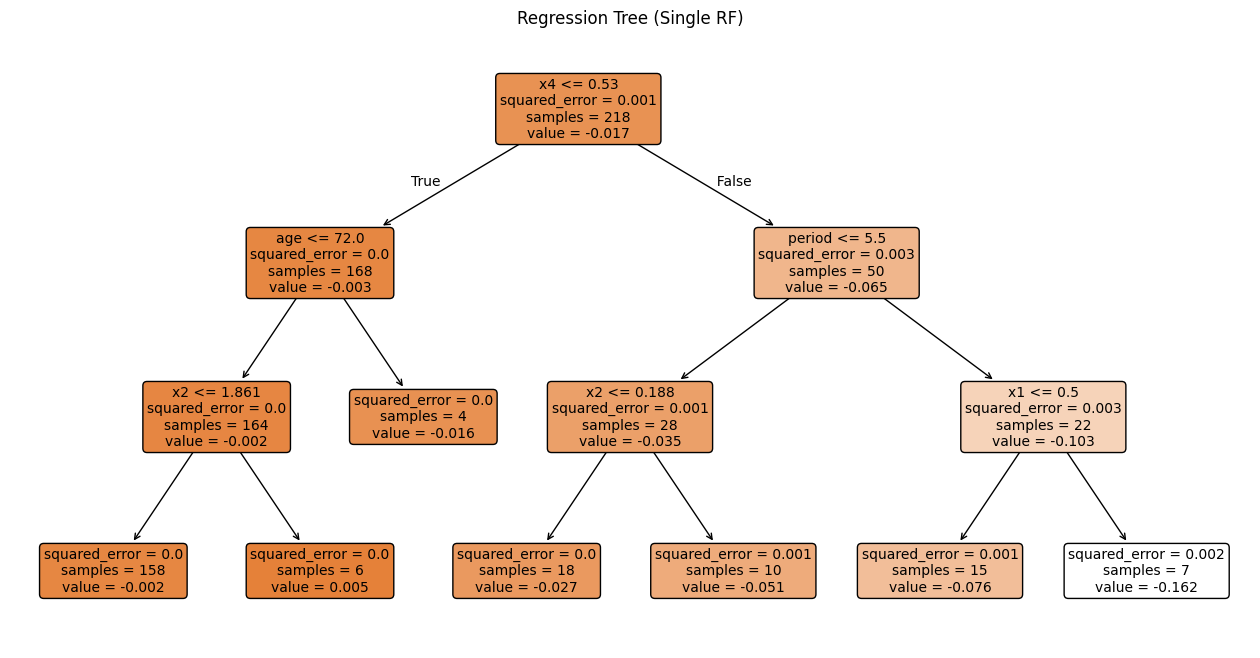

In [9]:
X_features = X_test.drop(columns=[treatment])

reg_SRF = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
reg_SRF.fit(X_features, SRF_ITE)

plt.figure(figsize=(16, 8))
plot_tree(
    reg_SRF,
    feature_names=X_features.columns,
    filled=True,        
    rounded=True,
    precision=3,
    fontsize=10
)

plt.title("Regression Tree (Single RF)")
plt.show()

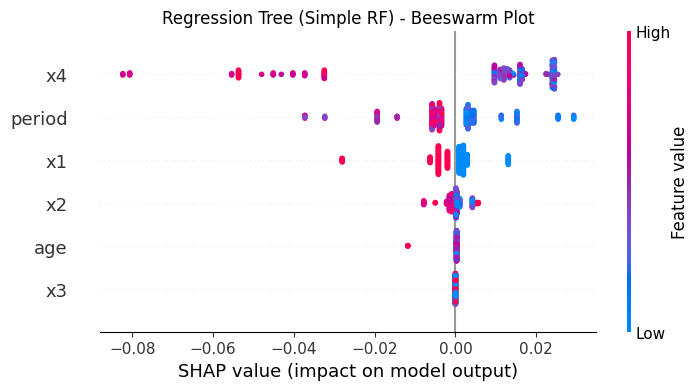

In [18]:
SRF_reg = shap.TreeExplainer(reg_SRF)
shap_SRF_reg = SRF_reg.shap_values(X_features)

shap_explanation_SRF = shap.Explanation(
    values=shap_SRF_reg, 
    data=X_features.values, 
    feature_names=X_features.columns.tolist()
)

shap.plots.beeswarm(shap_explanation_SRF, show=False)
plt.title("Regression Tree (Simple RF) - Beeswarm Plot")
plt.show()

In [11]:
# Single Random Forest
y_test_pos = y_test.reset_index(drop=True)

treated_idx = np.where(X_test[treatment].to_numpy() == 1)[0]
control_idx = np.where(X_test[treatment].to_numpy() == 0)[0]

treated_features = np.column_stack((Twin_1[treated_idx], Twin_2[treated_idx]))
control_features = np.column_stack((Twin_1[control_idx], Twin_2[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

pseudo_ITE_SRF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg_SRF = sm.add_constant(SRF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_SRF, linear_reg_SRF)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     14.45
Date:                Mon, 05 Jan 2026   Prob (F-statistic):           0.000241
Time:                        14:11:57   Log-Likelihood:                -59.603
No. Observations:                 108   AIC:                             123.2
Df Residuals:                     106   BIC:                             128.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3653      0.047     -7.795      0.0

In [13]:
treated_mask = (X_test[treatment] == 1)
model_ite_treated = SRF_ITE[treated_mask]

pred_direction = (model_ite_treated > 0).astype(int)
observed_direction = (pseudo_ITE_SRF > 0).astype(int)

accuracy = accuracy_score(observed_direction, pred_direction)
print(f"Classification Accuracy (Consistency with Pseudo-ITE): {accuracy:.4f}")

Classification Accuracy (Consistency with Pseudo-ITE): 0.9630
